# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
from os import makedirs
from os.path import isfile, isdir, join, exists

data_dir   = './data'
prefix     = '.'
pkl_folder = 'pkl-files'
pkl_prefix = join(prefix, pkl_folder)

pkl_sub    = 'saved_var_checkpoint'                  #sub-folder
pkl_subpth = join(pkl_prefix, pkl_sub)       #filename will be added at runtime 

chk_folder = 'checkpoints'
chk_prefix = join(prefix, chk_folder)

chk_sub    = 'historic_losses'                       #sub-folder
chk_subpth  = join(chk_prefix, chk_sub)       #filename will be added at runtime

f_names = [chk_subpth, pkl_subpth, data_dir]

for foldername in f_names:
    if not exists(foldername):
        makedirs(foldername)

if not isdir(pkl_subpth):
    raise Exception("pkl directory doesn't exist!")
if not isdir(chk_subpth):
    raise Exception("Checkpoints directory doesn't exist!")

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'

       
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
# pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
# pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), \
'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_dim      = (image_width, image_height, image_channels)
    inputs_real   = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z      = tf.placeholder(tf.float32, (None, z_dim),     name='input_z')
    learning_rate = tf.placeholder(tf.float32, None,              name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(r, alpha=0.2):
    return tf.maximum(alpha * r, r)

def array_product(array):
    result = 1
    for n in array:
        result *= int(n)
    return result

In [7]:
Dkeep_prob      = 0.4            # initialize

def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Using dropout in discrimnator, as a means to keep D-loss over G-loss,  
    # to allow the GAN -as a whole- to learn more effectively.
    
    global Dkeep_prob            
    
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    # no batch norm on the 1st layer
    with tf.variable_scope('discriminator', reuse=reuse):
        kernel_size = 4
        conv1 = tf.layers.conv2d(images, 128, kernel_size, strides=2, padding='same', kernel_initializer=kernel_init)
        drop1 = tf.layers.dropout(conv1, Dkeep_prob)
        leak1 = leaky_relu(drop1, alpha=alpha)
        #print("leak1.sh",leak1.shape) #leak1.sh (?, 14, 14, 128)
        
        conv2 = tf.layers.conv2d(leak1, 256, kernel_size, strides=2, padding='same', kernel_initializer=kernel_init)
        drop2 = tf.layers.dropout(conv2, Dkeep_prob)
        bnor2 = tf.layers.batch_normalization(drop2, training=True)
        leak2 = leaky_relu(bnor2, alpha=alpha)
        #print("leak2.sh",leak2.shape) # leak2.sh (?, 7, 7, 256)
        
        conv3 = tf.layers.conv2d(leak2, 512, kernel_size, strides=2, padding='same', kernel_initializer=kernel_init)
        drop3 = tf.layers.dropout(conv3, Dkeep_prob)
        bnor3 = tf.layers.batch_normalization(drop3, training=True)
        leak3 = leaky_relu(bnor3, alpha=alpha)
        #print("leak3.sh",leak3.shape) # leak3.sh (?, 4, 4, 512)
    
        shape4 = tf.reshape(leak3, [-1, array_product(leak3.get_shape()[1:])])
        #print("shape4.sh",shape4.shape) # shape4.sh (?, 8192)
        
        logits = tf.layers.dense(shape4, 1)
        output = tf.sigmoid(logits)
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
Gkeep_prob      = 0.5            # initialize

def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # I've expanded this gradually, but significantly in order to strengthen G
    # to give G "more room" for learning (and for dropout - to stabilize G)
    # the goal being though, to keep the G-loss lower than D-loss
    
    # print("z", z.shape)                    # z (?, 100)
    # target (28,28, out_channel_dim)

    # Gkeep_prob -another tool we use to make the G more steady, less irratic, less dependent on D
    global Gkeep_prob
    
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    with tf.variable_scope('generator', reuse=not is_train): 
        kernel_size = 4
        strde       = 2
        dense = tf.layers.dense(z, 4*4*512)
        # print("dense", dense.shape)         # dense (?, 8192)
        
        shape1 = tf.reshape(dense, [-1, 4, 4, 512])
            
        bnor1  = tf.layers.batch_normalization(shape1, training=is_train)
        leak1  = leaky_relu(bnor1)
        # print("leak1", leak1.shape)        # leak1 (?, 4, 4, 512)

        if is_train:
            drop1  = tf.layers.dropout(leak1, Gkeep_prob)
        else:
            drop1  = tf.layers.dropout(leak1, 1)
        
        tran2  = tf.layers.conv2d_transpose(drop1, 256, kernel_size, strides=strde, padding='same', \
                                            kernel_initializer=kernel_init)
        # print("tran2",tran2.shape)        # tran2 (?, 8, 8, 256)
        bili2  = tf.image.resize_images(tran2, [7, 7])    # default method=ResizeMethod.BILINEAR
        # print("bili2", bili2.shape)       # bili2 (?, 7, 7, 256)
        
        bnor3  = tf.layers.batch_normalization(bili2, training=is_train)
        leak3  = leaky_relu(bnor3)
        # print("leak3", leak3.shape)       # leak3 (?, 7, 7, 256)
        
        if is_train:
            drop3  = tf.layers.dropout(leak3, Gkeep_prob)
        else:
            drop3  = tf.layers.dropout(leak3, 1)
                
        tran3  = tf.layers.conv2d_transpose(drop3, 128, kernel_size, strides=strde, padding='same', \
                                            kernel_initializer=kernel_init)
        # print("tran3",tran3.shape)        # tran3 (?, 14, 14, 128)
        
        bnor4  = tf.layers.batch_normalization(tran3, training=is_train)
        leak4  = leaky_relu(bnor4)
        
        if is_train:
            drop4  = tf.layers.dropout(leak4, Gkeep_prob)
        else:
            drop4  = tf.layers.dropout(leak4, 1)
                                
        logits = tf.layers.conv2d_transpose(drop4, out_channel_dim, kernel_size, strides=strde, padding='same')
        # print("logits",logits.shape)    # logits (?, 28, 28, 5)
        
        # print("chan",out_channel_dim)   # chan 5
        output = tf.tanh(logits)

    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    d_loss_real = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                            labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                            labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
                tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                            labels=tf.ones_like(d_model_fake)))
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()


### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
import pickle as pkl

import time
import datetime
from datetime import timedelta 

def timestmp():
    print ("tmstmp")
    print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    
def split(start_time):
    split_time = time.time()
    time_dif   = split_time - start_time
    time_str = str(timedelta(seconds = int(time_dif)))
    return time_dif, time_str
    

In [13]:
import pylab 
import numpy as np

def plot_loss(losses, steps_graph):
    fig, ax = pyplot.subplots()
    step_list = [x* steps_graph for x in range(len(losses))]
    losses = np.array(losses)
    pyplot.plot(losses.T[0], label='Discriminator', alpha=0.5)
    pyplot.plot(losses.T[1], label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()
    pyplot.show()
    

In [14]:
from collections import deque
import numpy as np

def train(epochs, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epochs: Number of epochs pr. run
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # global
    global filename
    global Load_chk
    global steps_printline
    global steps_images
    global chkfilepth
    global pckfilepth
    global num_mv_avg    
    
    # var
    steps           = 0
    laststeps       = 0
    last_elapsed    = 0
    samples, losses = [], []
    start_time      = time.time()
    mov_av_list     = deque()
    
    image_dim = data_shape[1:]
    channels  = image_dim[-1]
    
    image_mode = "L" if channels == 1 else "RGB"
    
    input_real, input_z, lr = model_inputs(*image_dim, z_dim)
    d_loss, g_loss              = model_loss(input_real, input_z, channels)
    d_opt, g_opt                = model_opt(d_loss, g_loss, learning_rate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver           = tf.train.Saver()
        
        chk_suffix = '.chk'
        chkfilepth = os.path.join(chk_subpth, filename+chk_suffix)
        pkl_suffix = '.pkl'
        pklfilepth = os.path.join(pkl_subpth, filename+pkl_suffix)
        
        # we need to add .meta - to see that the 3 chkpoint files are present
        metapklfilepth = pklfilepth+'.meta'
        
        if (Load_chk==True):
            saver.restore(sess, chkfilepth)
            print('Model restored.')
            with open(pklfilepth, 'rb') as rl:
                losses = pkl.load(rl)
            print ('historic losses loaded')    
                
        timestmp    
        for epoch_i in range(epochs):
            line=0
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Sample noise
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                # Optimize
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})

            # 3 xtra optimizations inspired by the chats on SLACK and the orig. GAN paper
            # this is an attempt at stabilizing the Generator and countering the Discriminator 
            # overpowering the Generator so the G takes 1 little steps towards optimum - recalc  
            # - and 1 step towards opt - recalc. (4 times) 
            # (so even at a relatively small lr G should learn)
            # -- while D take one on the same batch

                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, 
                                               input_z: batch_z, 
                                               lr: learning_rate})
                                
                if steps % steps_printline == 0:
                    line+=1
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    elapsed_time, time_str = split(start_time)
                    elapsed_steps  = steps-laststeps
                    step_time      = elapsed_time-last_elapsed

                    if (len(mov_av_list)>num_mv_avg):
                        mov_av_list.popleft()
                        mov_av_list.append(step_time)
                    else:
                        mov_av_list.append(step_time)
                    mov_av = (np.mean(mov_av_list)/60)
                    
                    st_time_str    = str(timedelta(seconds = int(step_time)))
                    time_rest      = (((num_mv_avg*(epochs-(epoch_i+1)))+(num_mv_avg-line))*mov_av) 
                    #
                    print("Epoch:{:2}/{:2}".format(epoch_i+1, epochs),
                          "Time: {:8}s.".format(time_str),
                          "st_Tm: {:8}s.".format(st_time_str),
                          "mean:{:2.0f}m.".format(mov_av),
                          "#Steps:{:4},".format(steps),
                          "DLoss:{:7.4f}".format(train_loss_d),
                          "GLoss:{:7.4f}".format(train_loss_g),
                          "guess:{:4.0f}m.".format(time_rest))
                    #
                    laststeps = steps
                    last_elapsed = elapsed_time 
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if (steps == 1) or (steps % steps_images == 0): 
                    show_generator_output(sess, 25, input_z, channels, image_mode)
                    #
                    saver.save(sess, chkfilepth)
                    timestmp
                    print("checkpoint saved")
                    #
                    print("losses saved to: ",pklfilepth)    
                    with open(pklfilepth, 'wb') as wl:
                        pkl.dump(losses, wl)
                    #
                    if (steps == 1) and (Load_chk==True):
                        plot_loss(losses, steps_graph)
                    #
                if (steps % steps_graph == 0):
                    plot_loss(losses, steps_graph)
            #
        saver.save(sess, chkfilepth)
        timestmp
        print("checkpoint saved")
        #
        plot_loss(losses, steps_graph)
        show_generator_output(sess, 121, input_z, channels, image_mode)
        show_generator_output(sess, 64, input_z, channels, image_mode)
        show_generator_output(sess, 25, input_z, channels, image_mode)
        show_generator_output(sess, 4, input_z, channels, image_mode)
        
    print("pickle should open: ",pklfilepth)    
    with open(pklfilepth, 'wb') as wl:
        pkl.dump(losses, wl)
    print ("finished training {} epochs".format(epochs))

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

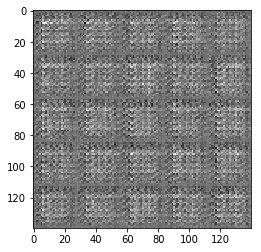

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 1/12 Time: 0:01:55 s. st_Tm: 0:01:55 s. mean: 2m. #Steps:  64, DLoss: 1.9123 GLoss: 0.2053 guess: 160m.
Epoch: 1/12 Time: 0:03:40 s. st_Tm: 0:01:45 s. mean: 2m. #Steps: 128, DLoss: 1.3173 GLoss: 0.4064 guess: 151m.
Epoch: 1/12 Time: 0:05:24 s. st_Tm: 0:01:43 s. mean: 2m. #Steps: 192, DLoss: 1.2226 GLoss: 0.5693 guess: 146m.
Epoch: 1/12 Time: 0:07:08 s. st_Tm: 0:01:44 s. mean: 2m. #Steps: 256, DLoss: 2.5831 GLoss: 0.0900 guess: 143m.


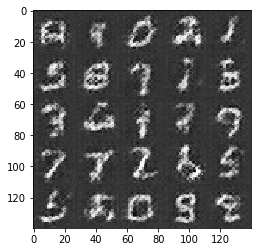

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 1/12 Time: 0:08:54 s. st_Tm: 0:01:45 s. mean: 2m. #Steps: 320, DLoss: 6.3925 GLoss: 0.6229 guess: 141m.
Epoch: 1/12 Time: 0:10:38 s. st_Tm: 0:01:43 s. mean: 2m. #Steps: 384, DLoss: 1.3156 GLoss: 0.4063 guess: 138m.
Epoch: 1/12 Time: 0:12:22 s. st_Tm: 0:01:44 s. mean: 2m. #Steps: 448, DLoss: 1.0432 GLoss: 0.7611 guess: 136m.
Epoch: 2/12 Time: 0:14:06 s. st_Tm: 0:01:44 s. mean: 2m. #Steps: 512, DLoss: 0.4539 GLoss: 3.2204 guess: 134m.


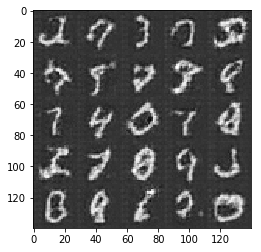

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl


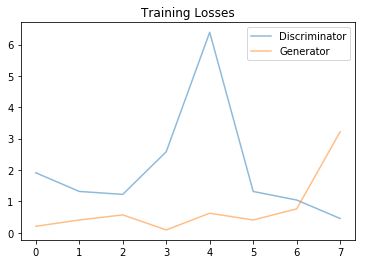

Epoch: 2/12 Time: 0:15:52 s. st_Tm: 0:01:46 s. mean: 2m. #Steps: 576, DLoss: 1.6590 GLoss: 0.2426 guess: 131m.
Epoch: 2/12 Time: 0:17:36 s. st_Tm: 0:01:43 s. mean: 2m. #Steps: 640, DLoss: 1.1694 GLoss: 0.4659 guess: 129m.
Epoch: 2/12 Time: 0:19:19 s. st_Tm: 0:01:43 s. mean: 2m. #Steps: 704, DLoss: 1.1679 GLoss: 0.7731 guess: 127m.
Epoch: 2/12 Time: 0:21:04 s. st_Tm: 0:01:44 s. mean: 2m. #Steps: 768, DLoss: 1.0567 GLoss: 0.5269 guess: 125m.


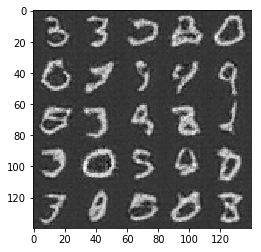

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 2/12 Time: 0:22:50 s. st_Tm: 0:01:46 s. mean: 2m. #Steps: 832, DLoss: 2.2075 GLoss: 0.1388 guess: 124m.
Epoch: 2/12 Time: 0:24:34 s. st_Tm: 0:01:44 s. mean: 2m. #Steps: 896, DLoss: 1.3081 GLoss: 0.4209 guess: 122m.
Epoch: 3/12 Time: 0:26:18 s. st_Tm: 0:01:43 s. mean: 2m. #Steps: 960, DLoss: 0.8744 GLoss: 1.0368 guess: 120m.
Epoch: 3/12 Time: 0:28:03 s. st_Tm: 0:01:45 s. mean: 2m. #Steps:1024, DLoss: 0.4203 GLoss: 2.0706 guess: 119m.


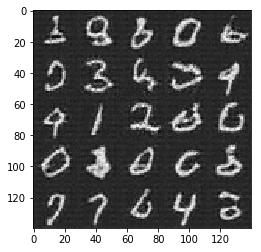

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl


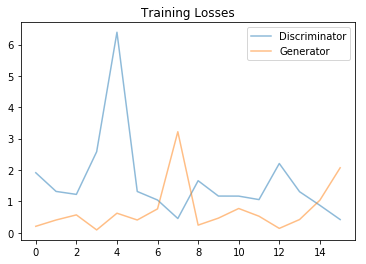

Epoch: 3/12 Time: 0:29:50 s. st_Tm: 0:01:46 s. mean: 2m. #Steps:1088, DLoss: 1.5897 GLoss: 0.2834 guess: 117m.
Epoch: 3/12 Time: 0:31:34 s. st_Tm: 0:01:43 s. mean: 2m. #Steps:1152, DLoss: 0.5238 GLoss: 1.1295 guess: 115m.
Epoch: 3/12 Time: 0:33:20 s. st_Tm: 0:01:45 s. mean: 2m. #Steps:1216, DLoss: 0.8522 GLoss: 1.1794 guess: 114m.
Epoch: 3/12 Time: 0:35:06 s. st_Tm: 0:01:46 s. mean: 2m. #Steps:1280, DLoss: 0.2069 GLoss: 2.1657 guess: 112m.


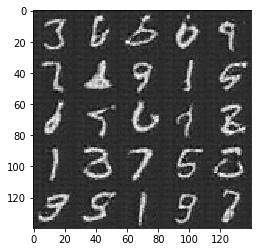

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 3/12 Time: 0:36:51 s. st_Tm: 0:01:44 s. mean: 2m. #Steps:1344, DLoss: 0.8010 GLoss: 0.7993 guess: 110m.
Epoch: 4/12 Time: 0:38:34 s. st_Tm: 0:01:42 s. mean: 2m. #Steps:1408, DLoss: 1.9751 GLoss: 0.1851 guess: 108m.
Epoch: 4/12 Time: 0:40:16 s. st_Tm: 0:01:42 s. mean: 2m. #Steps:1472, DLoss: 1.3839 GLoss: 0.3981 guess: 107m.
Epoch: 4/12 Time: 0:41:59 s. st_Tm: 0:01:42 s. mean: 2m. #Steps:1536, DLoss: 1.7157 GLoss: 0.2790 guess: 104m.


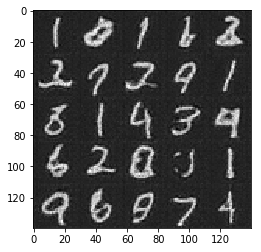

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl


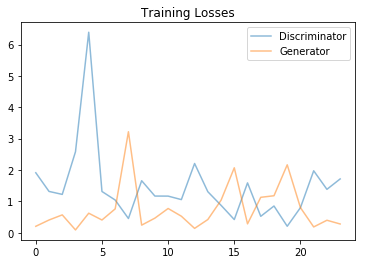

Epoch: 4/12 Time: 0:43:43 s. st_Tm: 0:01:44 s. mean: 2m. #Steps:1600, DLoss: 2.2036 GLoss: 0.1479 guess: 102m.
Epoch: 4/12 Time: 0:45:26 s. st_Tm: 0:01:42 s. mean: 2m. #Steps:1664, DLoss: 2.0725 GLoss: 0.1665 guess: 101m.
Epoch: 4/12 Time: 0:47:08 s. st_Tm: 0:01:42 s. mean: 2m. #Steps:1728, DLoss: 1.2459 GLoss: 0.6423 guess:  98m.
Epoch: 4/12 Time: 0:48:51 s. st_Tm: 0:01:42 s. mean: 2m. #Steps:1792, DLoss: 0.9977 GLoss: 1.5885 guess:  96m.


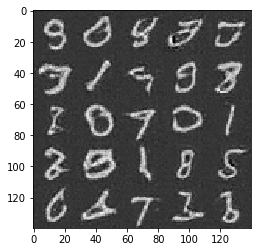

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 4/12 Time: 0:50:35 s. st_Tm: 0:01:44 s. mean: 2m. #Steps:1856, DLoss: 1.8578 GLoss: 0.2189 guess:  94m.
Epoch: 5/12 Time: 0:52:18 s. st_Tm: 0:01:43 s. mean: 2m. #Steps:1920, DLoss: 1.3419 GLoss: 0.3665 guess:  94m.
Epoch: 5/12 Time: 0:54:01 s. st_Tm: 0:01:42 s. mean: 2m. #Steps:1984, DLoss: 1.0306 GLoss: 0.5553 guess:  93m.
Epoch: 5/12 Time: 0:55:45 s. st_Tm: 0:01:43 s. mean: 2m. #Steps:2048, DLoss: 0.9735 GLoss: 1.0732 guess:  91m.


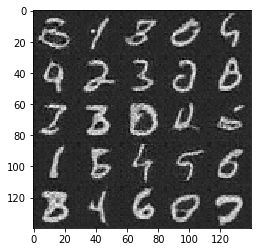

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl


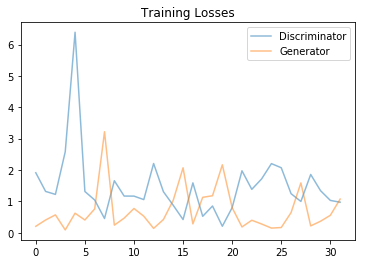

Epoch: 5/12 Time: 0:57:29 s. st_Tm: 0:01:44 s. mean: 2m. #Steps:2112, DLoss: 0.8075 GLoss: 0.9803 guess:  89m.
Epoch: 5/12 Time: 0:59:12 s. st_Tm: 0:01:42 s. mean: 2m. #Steps:2176, DLoss: 1.8305 GLoss: 0.2200 guess:  88m.
Epoch: 5/12 Time: 1:00:54 s. st_Tm: 0:01:42 s. mean: 2m. #Steps:2240, DLoss: 0.6502 GLoss: 0.9704 guess:  86m.
Epoch: 5/12 Time: 1:02:37 s. st_Tm: 0:01:42 s. mean: 2m. #Steps:2304, DLoss: 0.7758 GLoss: 1.5717 guess:  84m.


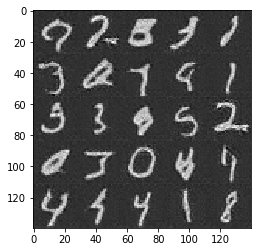

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 6/12 Time: 1:04:21 s. st_Tm: 0:01:44 s. mean: 2m. #Steps:2368, DLoss: 1.5343 GLoss: 0.3934 guess:  83m.
Epoch: 6/12 Time: 1:06:05 s. st_Tm: 0:01:43 s. mean: 2m. #Steps:2432, DLoss: 0.9904 GLoss: 0.7998 guess:  81m.
Epoch: 6/12 Time: 1:07:55 s. st_Tm: 0:01:50 s. mean: 2m. #Steps:2496, DLoss: 2.7589 GLoss: 0.0857 guess:  80m.
Epoch: 6/12 Time: 1:09:40 s. st_Tm: 0:01:45 s. mean: 2m. #Steps:2560, DLoss: 1.9647 GLoss: 0.1943 guess:  78m.


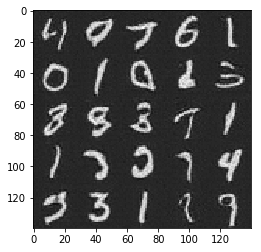

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl


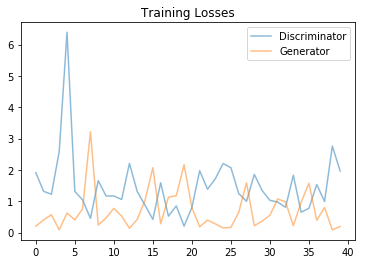

Epoch: 6/12 Time: 1:11:27 s. st_Tm: 0:01:47 s. mean: 2m. #Steps:2624, DLoss: 1.1990 GLoss: 0.8608 guess:  77m.
Epoch: 6/12 Time: 1:13:12 s. st_Tm: 0:01:44 s. mean: 2m. #Steps:2688, DLoss: 2.1389 GLoss: 0.1706 guess:  75m.
Epoch: 6/12 Time: 1:14:57 s. st_Tm: 0:01:45 s. mean: 2m. #Steps:2752, DLoss: 2.1735 GLoss: 0.1630 guess:  74m.
Epoch: 7/12 Time: 1:16:44 s. st_Tm: 0:01:46 s. mean: 2m. #Steps:2816, DLoss: 1.1886 GLoss: 0.5536 guess:  72m.


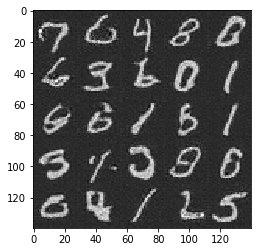

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 7/12 Time: 1:18:30 s. st_Tm: 0:01:46 s. mean: 2m. #Steps:2880, DLoss: 0.7701 GLoss: 1.5573 guess:  71m.
Epoch: 7/12 Time: 1:20:14 s. st_Tm: 0:01:43 s. mean: 2m. #Steps:2944, DLoss: 1.8075 GLoss: 0.2438 guess:  69m.
Epoch: 7/12 Time: 1:22:21 s. st_Tm: 0:02:07 s. mean: 2m. #Steps:3008, DLoss: 0.0665 GLoss: 6.4929 guess:  69m.
Epoch: 7/12 Time: 1:24:36 s. st_Tm: 0:02:14 s. mean: 2m. #Steps:3072, DLoss: 1.0060 GLoss: 0.6157 guess:  69m.


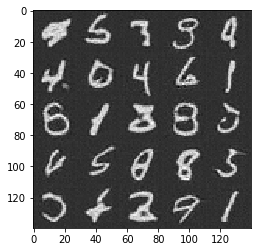

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl


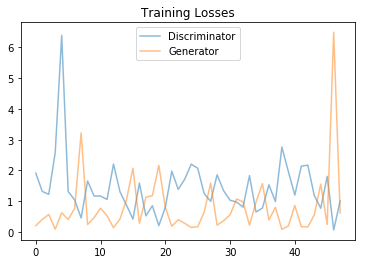

Epoch: 7/12 Time: 1:26:55 s. st_Tm: 0:02:18 s. mean: 2m. #Steps:3136, DLoss: 1.2537 GLoss: 0.4912 guess:  70m.
Epoch: 7/12 Time: 1:29:14 s. st_Tm: 0:02:19 s. mean: 2m. #Steps:3200, DLoss: 0.8591 GLoss: 0.8898 guess:  70m.
Epoch: 7/12 Time: 1:31:28 s. st_Tm: 0:02:13 s. mean: 2m. #Steps:3264, DLoss: 0.5126 GLoss: 1.1431 guess:  70m.
Epoch: 8/12 Time: 1:33:41 s. st_Tm: 0:02:12 s. mean: 2m. #Steps:3328, DLoss: 2.6671 GLoss: 0.0959 guess:  72m.


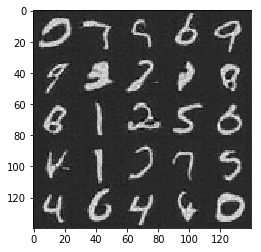

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 8/12 Time: 1:35:57 s. st_Tm: 0:02:16 s. mean: 2m. #Steps:3392, DLoss: 1.9298 GLoss: 0.2095 guess:  72m.
Epoch: 8/12 Time: 1:38:17 s. st_Tm: 0:02:20 s. mean: 2m. #Steps:3456, DLoss: 0.8795 GLoss: 1.1657 guess:  72m.
Epoch: 8/12 Time: 1:40:39 s. st_Tm: 0:02:21 s. mean: 2m. #Steps:3520, DLoss: 1.5609 GLoss: 0.3278 guess:  71m.
Epoch: 8/12 Time: 1:42:58 s. st_Tm: 0:02:19 s. mean: 2m. #Steps:3584, DLoss: 1.0969 GLoss: 0.8070 guess:  69m.


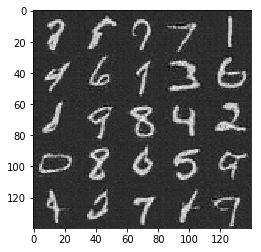

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl


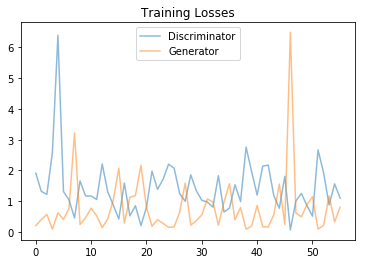

Epoch: 8/12 Time: 1:45:22 s. st_Tm: 0:02:23 s. mean: 2m. #Steps:3648, DLoss: 1.8478 GLoss: 0.2270 guess:  67m.
Epoch: 8/12 Time: 1:47:44 s. st_Tm: 0:02:21 s. mean: 2m. #Steps:3712, DLoss: 2.8799 GLoss: 0.0819 guess:  65m.
Epoch: 9/12 Time: 1:50:07 s. st_Tm: 0:02:22 s. mean: 2m. #Steps:3776, DLoss: 2.4741 GLoss: 0.1130 guess:  63m.
Epoch: 9/12 Time: 1:52:29 s. st_Tm: 0:02:22 s. mean: 2m. #Steps:3840, DLoss: 1.5805 GLoss: 0.2997 guess:  61m.


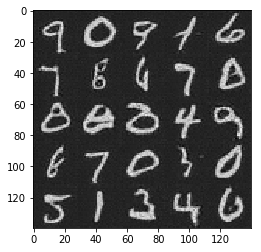

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch: 9/12 Time: 1:54:49 s. st_Tm: 0:02:20 s. mean: 2m. #Steps:3904, DLoss: 1.8481 GLoss: 0.2525 guess:  59m.
Epoch: 9/12 Time: 1:57:14 s. st_Tm: 0:02:24 s. mean: 2m. #Steps:3968, DLoss: 1.3017 GLoss: 0.4587 guess:  57m.
Epoch: 9/12 Time: 1:59:35 s. st_Tm: 0:02:21 s. mean: 2m. #Steps:4032, DLoss: 2.1029 GLoss: 0.1944 guess:  54m.
Epoch: 9/12 Time: 2:01:55 s. st_Tm: 0:02:20 s. mean: 2m. #Steps:4096, DLoss: 3.1787 GLoss: 0.0589 guess:  52m.


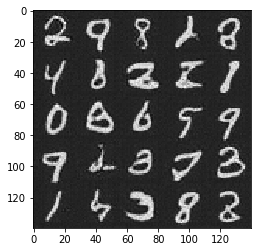

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl


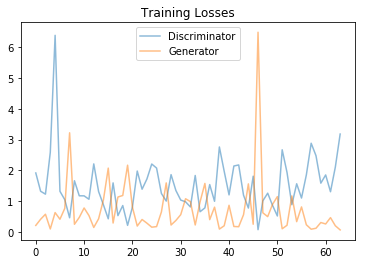

Epoch: 9/12 Time: 2:04:16 s. st_Tm: 0:02:21 s. mean: 2m. #Steps:4160, DLoss: 0.8777 GLoss: 1.1552 guess:  50m.
Epoch:10/12 Time: 2:06:41 s. st_Tm: 0:02:24 s. mean: 2m. #Steps:4224, DLoss: 2.4949 GLoss: 0.1231 guess:  47m.
Epoch:10/12 Time: 2:09:02 s. st_Tm: 0:02:21 s. mean: 2m. #Steps:4288, DLoss: 2.1084 GLoss: 0.1684 guess:  45m.
Epoch:10/12 Time: 2:11:23 s. st_Tm: 0:02:20 s. mean: 2m. #Steps:4352, DLoss: 2.6449 GLoss: 0.1070 guess:  43m.


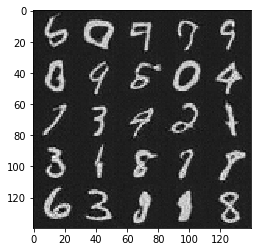

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch:10/12 Time: 2:13:54 s. st_Tm: 0:02:31 s. mean: 2m. #Steps:4416, DLoss: 1.3710 GLoss: 0.4254 guess:  41m.
Epoch:10/12 Time: 2:16:21 s. st_Tm: 0:02:26 s. mean: 2m. #Steps:4480, DLoss: 0.9990 GLoss: 1.4734 guess:  38m.
Epoch:10/12 Time: 2:18:37 s. st_Tm: 0:02:15 s. mean: 2m. #Steps:4544, DLoss: 1.4860 GLoss: 0.3688 guess:  36m.
Epoch:10/12 Time: 2:20:54 s. st_Tm: 0:02:16 s. mean: 2m. #Steps:4608, DLoss: 2.2125 GLoss: 0.1638 guess:  33m.


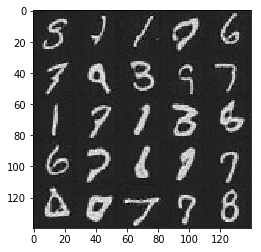

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl


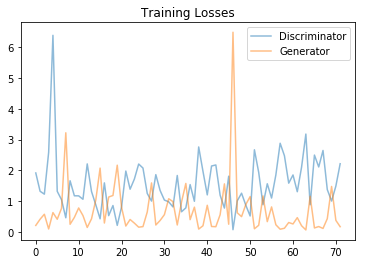

Epoch:10/12 Time: 2:23:12 s. st_Tm: 0:02:18 s. mean: 2m. #Steps:4672, DLoss: 1.0791 GLoss: 0.5914 guess:  31m.
Epoch:11/12 Time: 2:25:34 s. st_Tm: 0:02:21 s. mean: 2m. #Steps:4736, DLoss: 2.7785 GLoss: 0.0864 guess:  31m.
Epoch:11/12 Time: 2:27:55 s. st_Tm: 0:02:20 s. mean: 2m. #Steps:4800, DLoss: 1.4861 GLoss: 0.4002 guess:  28m.
Epoch:11/12 Time: 2:30:15 s. st_Tm: 0:02:20 s. mean: 2m. #Steps:4864, DLoss: 1.1633 GLoss: 0.6110 guess:  26m.


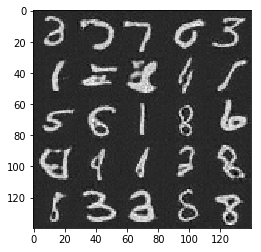

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch:11/12 Time: 2:32:38 s. st_Tm: 0:02:22 s. mean: 2m. #Steps:4928, DLoss: 1.9084 GLoss: 0.2366 guess:  23m.
Epoch:11/12 Time: 2:35:00 s. st_Tm: 0:02:21 s. mean: 2m. #Steps:4992, DLoss: 1.3011 GLoss: 0.5184 guess:  21m.
Epoch:11/12 Time: 2:37:22 s. st_Tm: 0:02:21 s. mean: 2m. #Steps:5056, DLoss: 0.9574 GLoss: 0.7092 guess:  19m.
Epoch:11/12 Time: 2:39:44 s. st_Tm: 0:02:22 s. mean: 2m. #Steps:5120, DLoss: 1.5767 GLoss: 0.3147 guess:  16m.


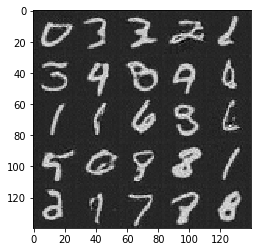

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl


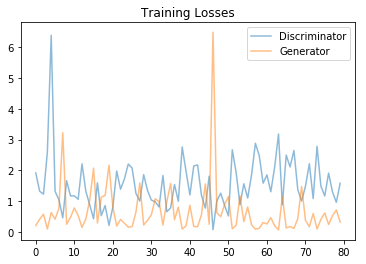

Epoch:12/12 Time: 2:42:09 s. st_Tm: 0:02:25 s. mean: 2m. #Steps:5184, DLoss: 1.0837 GLoss: 1.6823 guess:  14m.
Epoch:12/12 Time: 2:44:36 s. st_Tm: 0:02:26 s. mean: 2m. #Steps:5248, DLoss: 1.4245 GLoss: 0.3603 guess:  12m.
Epoch:12/12 Time: 2:46:59 s. st_Tm: 0:02:22 s. mean: 2m. #Steps:5312, DLoss: 3.7441 GLoss: 0.0341 guess:  10m.
Epoch:12/12 Time: 2:49:19 s. st_Tm: 0:02:20 s. mean: 2m. #Steps:5376, DLoss: 2.5658 GLoss: 0.1159 guess:   7m.


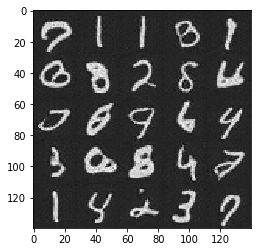

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
Epoch:12/12 Time: 2:51:43 s. st_Tm: 0:02:23 s. mean: 2m. #Steps:5440, DLoss: 2.7277 GLoss: 0.1121 guess:   5m.
Epoch:12/12 Time: 2:54:02 s. st_Tm: 0:02:18 s. mean: 2m. #Steps:5504, DLoss: 2.5038 GLoss: 0.1232 guess:   2m.
Epoch:12/12 Time: 2:56:22 s. st_Tm: 0:02:20 s. mean: 2m. #Steps:5568, DLoss: 2.0713 GLoss: 1.8582 guess:   0m.
checkpoint saved


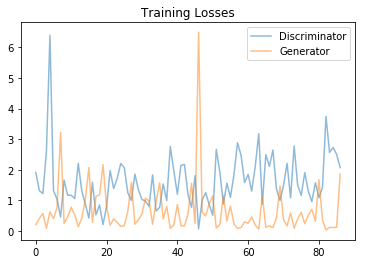

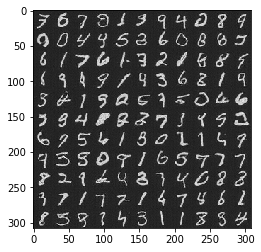

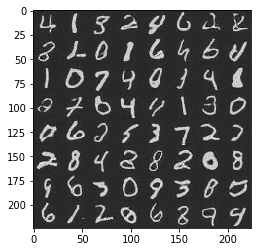

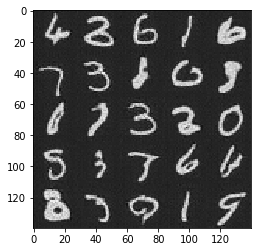

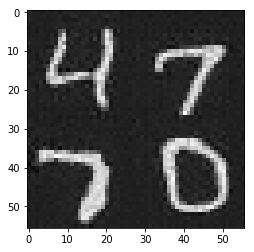

pickle should open:  ./pkl-files/saved_var_checkpoint/MNIST_run.pkl
finished training 12 epochs


In [16]:
"""
# GLOBAL VAR 
- rather than changing the params train() uses - I added these params as global 
- which I know is not strictly right, but it works for me.
"""
# std. Hyper param
batch_size      = 128
z_dim           = 100

# I created a spreadsheet to try and understand beta1, beta2, m_0, v_0 - ended up with a much higher lr
# I can't say anything other than: these hyperparam worked for me - hope they will for you too.
learning_rate   = 0.0002
beta1           = 0.5

# to seperate the two data-runs, I will have to give the files different names 
filename        = 'MNIST_run'

#set this to [ True ], if you want to load the checkpoint and loss-file
Load_chk        =  False         #True

Gkeep_prob      = 0.5          
Dkeep_prob      = 0.3          

num_mv_avg      =  7 
steps_printline =  64 
steps_images    = 256 

steps_graph     = 512 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 12

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

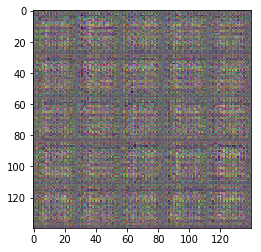

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 1/ 8 Time: 0:05:40 s. st_Tm: 0:05:40 s. mean: 6m. #Steps:  64, DLoss: 2.1712 GLoss: 0.3845 guess: 540m.
Epoch: 1/ 8 Time: 0:11:02 s. st_Tm: 0:05:21 s. mean: 6m. #Steps: 128, DLoss: 1.9510 GLoss: 0.4981 guess: 519m.
Epoch: 1/ 8 Time: 0:16:19 s. st_Tm: 0:05:17 s. mean: 5m. #Steps: 192, DLoss: 1.5358 GLoss: 0.6581 guess: 506m.
Epoch: 1/ 8 Time: 0:21:40 s. st_Tm: 0:05:20 s. mean: 5m. #Steps: 256, DLoss: 1.6106 GLoss: 0.6507 guess: 499m.


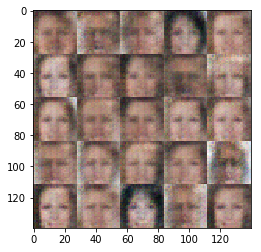

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 1/ 8 Time: 0:27:01 s. st_Tm: 0:05:20 s. mean: 5m. #Steps: 320, DLoss: 1.6785 GLoss: 0.5488 guess: 492m.
Epoch: 1/ 8 Time: 0:32:18 s. st_Tm: 0:05:17 s. mean: 5m. #Steps: 384, DLoss: 1.6259 GLoss: 0.5458 guess: 485m.
Epoch: 1/ 8 Time: 0:37:47 s. st_Tm: 0:05:28 s. mean: 5m. #Steps: 448, DLoss: 1.6805 GLoss: 0.5422 guess: 480m.
Epoch: 1/ 8 Time: 0:43:04 s. st_Tm: 0:05:17 s. mean: 5m. #Steps: 512, DLoss: 1.4572 GLoss: 0.6223 guess: 474m.


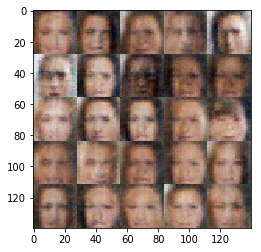

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl


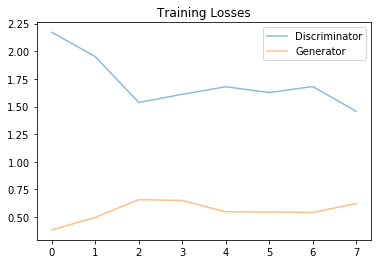

Epoch: 1/ 8 Time: 0:48:25 s. st_Tm: 0:05:20 s. mean: 5m. #Steps: 576, DLoss: 1.5937 GLoss: 0.5627 guess: 468m.
Epoch: 1/ 8 Time: 0:53:43 s. st_Tm: 0:05:17 s. mean: 5m. #Steps: 640, DLoss: 1.4491 GLoss: 0.6396 guess: 462m.
Epoch: 1/ 8 Time: 0:59:00 s. st_Tm: 0:05:17 s. mean: 5m. #Steps: 704, DLoss: 1.4580 GLoss: 0.5929 guess: 456m.
Epoch: 1/ 8 Time: 1:03:29 s. st_Tm: 0:04:28 s. mean: 5m. #Steps: 768, DLoss: 1.4802 GLoss: 0.6456 guess: 444m.


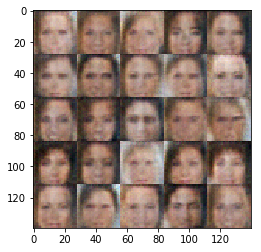

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 2/ 8 Time: 1:07:26 s. st_Tm: 0:03:57 s. mean: 5m. #Steps: 832, DLoss: 1.5062 GLoss: 0.6487 guess: 431m.
Epoch: 2/ 8 Time: 1:11:05 s. st_Tm: 0:03:39 s. mean: 5m. #Steps: 896, DLoss: 1.5893 GLoss: 0.6203 guess: 413m.
Epoch: 2/ 8 Time: 1:14:42 s. st_Tm: 0:03:37 s. mean: 5m. #Steps: 960, DLoss: 1.4641 GLoss: 0.6477 guess: 397m.
Epoch: 2/ 8 Time: 1:18:20 s. st_Tm: 0:03:37 s. mean: 5m. #Steps:1024, DLoss: 1.5079 GLoss: 0.5747 guess: 382m.


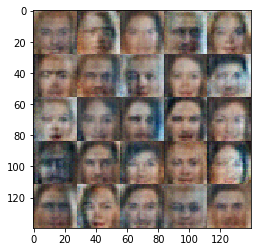

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl


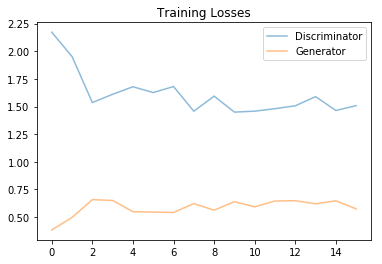

Epoch: 2/ 8 Time: 1:22:02 s. st_Tm: 0:03:41 s. mean: 5m. #Steps:1088, DLoss: 1.5901 GLoss: 0.5904 guess: 367m.
Epoch: 2/ 8 Time: 1:25:41 s. st_Tm: 0:03:39 s. mean: 5m. #Steps:1152, DLoss: 1.5125 GLoss: 0.6086 guess: 352m.
Epoch: 2/ 8 Time: 1:29:19 s. st_Tm: 0:03:38 s. mean: 4m. #Steps:1216, DLoss: 1.4266 GLoss: 0.6540 guess: 338m.
Epoch: 2/ 8 Time: 1:32:58 s. st_Tm: 0:03:38 s. mean: 4m. #Steps:1280, DLoss: 1.4904 GLoss: 0.6268 guess: 323m.


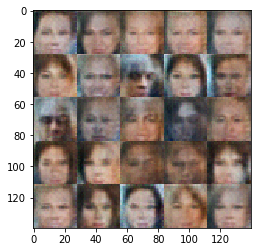

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 2/ 8 Time: 1:36:37 s. st_Tm: 0:03:39 s. mean: 4m. #Steps:1344, DLoss: 1.5184 GLoss: 0.5986 guess: 309m.
Epoch: 2/ 8 Time: 1:40:15 s. st_Tm: 0:03:37 s. mean: 4m. #Steps:1408, DLoss: 1.4816 GLoss: 0.6211 guess: 295m.
Epoch: 2/ 8 Time: 1:43:57 s. st_Tm: 0:03:41 s. mean: 4m. #Steps:1472, DLoss: 1.5007 GLoss: 0.5894 guess: 282m.
Epoch: 2/ 8 Time: 1:47:36 s. st_Tm: 0:03:39 s. mean: 4m. #Steps:1536, DLoss: 1.4738 GLoss: 0.6253 guess: 269m.


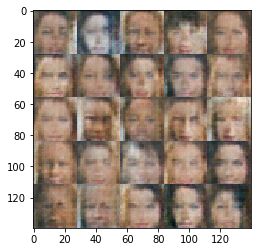

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl


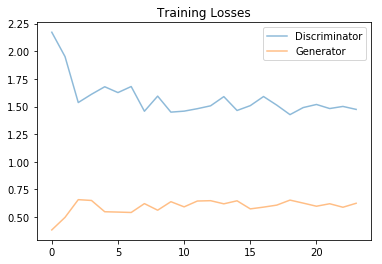

Epoch: 3/ 8 Time: 1:51:17 s. st_Tm: 0:03:40 s. mean: 4m. #Steps:1600, DLoss: 1.5727 GLoss: 0.6870 guess: 261m.
Epoch: 3/ 8 Time: 1:54:53 s. st_Tm: 0:03:36 s. mean: 4m. #Steps:1664, DLoss: 1.4652 GLoss: 0.6663 guess: 256m.
Epoch: 3/ 8 Time: 1:58:32 s. st_Tm: 0:03:38 s. mean: 4m. #Steps:1728, DLoss: 1.4495 GLoss: 0.7100 guess: 252m.
Epoch: 3/ 8 Time: 2:02:10 s. st_Tm: 0:03:37 s. mean: 4m. #Steps:1792, DLoss: 1.4603 GLoss: 0.7073 guess: 248m.


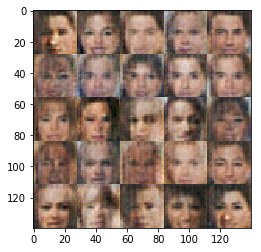

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 3/ 8 Time: 2:05:50 s. st_Tm: 0:03:40 s. mean: 4m. #Steps:1856, DLoss: 1.4092 GLoss: 0.6574 guess: 245m.
Epoch: 3/ 8 Time: 2:09:34 s. st_Tm: 0:03:44 s. mean: 4m. #Steps:1920, DLoss: 1.4477 GLoss: 0.6105 guess: 241m.
Epoch: 3/ 8 Time: 2:13:23 s. st_Tm: 0:03:49 s. mean: 4m. #Steps:1984, DLoss: 1.4484 GLoss: 0.6579 guess: 239m.
Epoch: 3/ 8 Time: 2:17:03 s. st_Tm: 0:03:39 s. mean: 4m. #Steps:2048, DLoss: 1.4371 GLoss: 0.6437 guess: 235m.


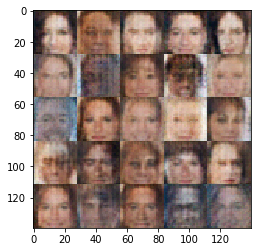

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl


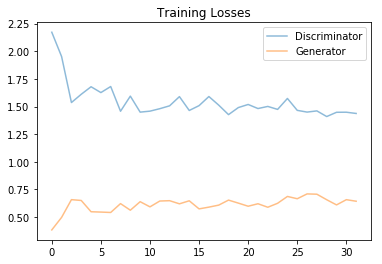

Epoch: 3/ 8 Time: 2:20:47 s. st_Tm: 0:03:43 s. mean: 4m. #Steps:2112, DLoss: 1.4184 GLoss: 0.6912 guess: 232m.
Epoch: 3/ 8 Time: 2:24:28 s. st_Tm: 0:03:41 s. mean: 4m. #Steps:2176, DLoss: 1.4294 GLoss: 0.6982 guess: 228m.
Epoch: 3/ 8 Time: 2:28:09 s. st_Tm: 0:03:41 s. mean: 4m. #Steps:2240, DLoss: 1.4529 GLoss: 0.6467 guess: 225m.
Epoch: 3/ 8 Time: 2:31:49 s. st_Tm: 0:03:39 s. mean: 4m. #Steps:2304, DLoss: 1.4239 GLoss: 0.6468 guess: 221m.


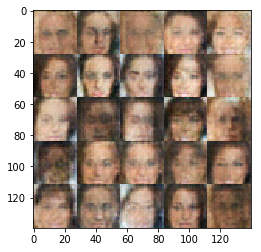

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 3/ 8 Time: 2:35:31 s. st_Tm: 0:03:41 s. mean: 4m. #Steps:2368, DLoss: 1.4067 GLoss: 0.6611 guess: 217m.
Epoch: 4/ 8 Time: 2:39:10 s. st_Tm: 0:03:39 s. mean: 4m. #Steps:2432, DLoss: 1.4414 GLoss: 0.6619 guess: 217m.
Epoch: 4/ 8 Time: 2:42:48 s. st_Tm: 0:03:37 s. mean: 4m. #Steps:2496, DLoss: 1.4134 GLoss: 0.6756 guess: 214m.
Epoch: 4/ 8 Time: 2:46:29 s. st_Tm: 0:03:41 s. mean: 4m. #Steps:2560, DLoss: 1.4512 GLoss: 0.6927 guess: 210m.


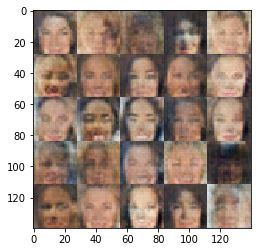

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl


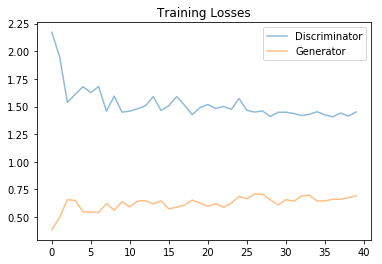

Epoch: 4/ 8 Time: 2:50:12 s. st_Tm: 0:03:43 s. mean: 4m. #Steps:2624, DLoss: 1.4489 GLoss: 0.6549 guess: 207m.
Epoch: 4/ 8 Time: 2:53:54 s. st_Tm: 0:03:41 s. mean: 4m. #Steps:2688, DLoss: 1.4600 GLoss: 0.6243 guess: 203m.
Epoch: 4/ 8 Time: 2:57:35 s. st_Tm: 0:03:41 s. mean: 4m. #Steps:2752, DLoss: 1.4589 GLoss: 0.7001 guess: 199m.
Epoch: 4/ 8 Time: 3:01:18 s. st_Tm: 0:03:42 s. mean: 4m. #Steps:2816, DLoss: 1.4156 GLoss: 0.6698 guess: 195m.


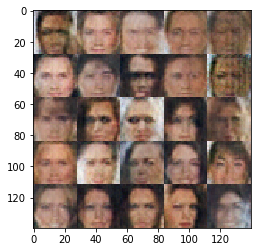

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 4/ 8 Time: 3:05:01 s. st_Tm: 0:03:42 s. mean: 4m. #Steps:2880, DLoss: 1.4268 GLoss: 0.6550 guess: 192m.
Epoch: 4/ 8 Time: 3:09:06 s. st_Tm: 0:04:05 s. mean: 4m. #Steps:2944, DLoss: 1.4581 GLoss: 0.6680 guess: 190m.
Epoch: 4/ 8 Time: 3:13:55 s. st_Tm: 0:04:48 s. mean: 4m. #Steps:3008, DLoss: 1.4087 GLoss: 0.6437 guess: 190m.
Epoch: 4/ 8 Time: 3:18:36 s. st_Tm: 0:04:40 s. mean: 4m. #Steps:3072, DLoss: 1.4272 GLoss: 0.7015 guess: 190m.


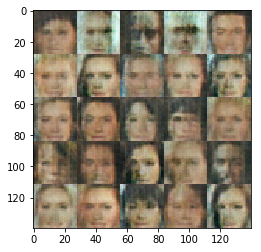

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl


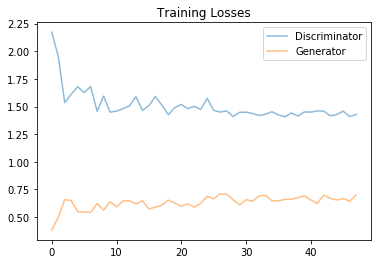

Epoch: 4/ 8 Time: 3:23:17 s. st_Tm: 0:04:41 s. mean: 4m. #Steps:3136, DLoss: 1.4974 GLoss: 0.6430 guess: 190m.
Epoch: 5/ 8 Time: 3:28:11 s. st_Tm: 0:04:53 s. mean: 4m. #Steps:3200, DLoss: 1.4171 GLoss: 0.6280 guess: 190m.
Epoch: 5/ 8 Time: 3:33:03 s. st_Tm: 0:04:51 s. mean: 4m. #Steps:3264, DLoss: 1.4243 GLoss: 0.6633 guess: 191m.
Epoch: 5/ 8 Time: 3:37:47 s. st_Tm: 0:04:44 s. mean: 4m. #Steps:3328, DLoss: 1.7019 GLoss: 0.6024 guess: 190m.


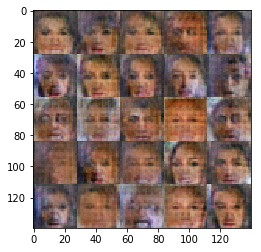

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 5/ 8 Time: 3:42:37 s. st_Tm: 0:04:49 s. mean: 4m. #Steps:3392, DLoss: 1.3993 GLoss: 0.6632 guess: 190m.
Epoch: 5/ 8 Time: 3:47:24 s. st_Tm: 0:04:47 s. mean: 4m. #Steps:3456, DLoss: 1.4015 GLoss: 0.6826 guess: 189m.
Epoch: 5/ 8 Time: 3:52:15 s. st_Tm: 0:04:50 s. mean: 4m. #Steps:3520, DLoss: 1.4712 GLoss: 0.6470 guess: 189m.
Epoch: 5/ 8 Time: 3:56:54 s. st_Tm: 0:04:39 s. mean: 5m. #Steps:3584, DLoss: 1.4108 GLoss: 0.6538 guess: 187m.


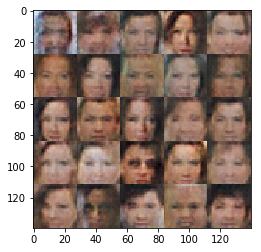

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl


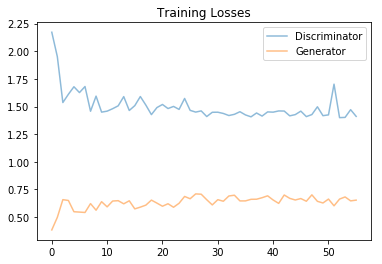

Epoch: 5/ 8 Time: 4:01:44 s. st_Tm: 0:04:49 s. mean: 5m. #Steps:3648, DLoss: 1.4151 GLoss: 0.7112 guess: 186m.
Epoch: 5/ 8 Time: 4:06:26 s. st_Tm: 0:04:41 s. mean: 5m. #Steps:3712, DLoss: 1.4133 GLoss: 0.7073 guess: 184m.
Epoch: 5/ 8 Time: 4:11:12 s. st_Tm: 0:04:46 s. mean: 5m. #Steps:3776, DLoss: 1.4149 GLoss: 0.6253 guess: 182m.
Epoch: 5/ 8 Time: 4:15:17 s. st_Tm: 0:04:05 s. mean: 5m. #Steps:3840, DLoss: 1.4042 GLoss: 0.6761 guess: 175m.


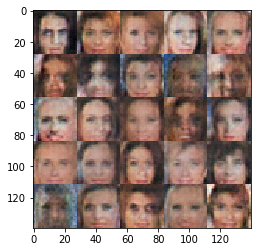

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 5/ 8 Time: 4:18:59 s. st_Tm: 0:03:41 s. mean: 5m. #Steps:3904, DLoss: 1.4602 GLoss: 0.6817 guess: 167m.
Epoch: 6/ 8 Time: 4:22:49 s. st_Tm: 0:03:50 s. mean: 5m. #Steps:3968, DLoss: 1.4312 GLoss: 0.6352 guess: 160m.
Epoch: 6/ 8 Time: 4:26:33 s. st_Tm: 0:03:43 s. mean: 4m. #Steps:4032, DLoss: 1.4491 GLoss: 0.6397 guess: 153m.
Epoch: 6/ 8 Time: 4:30:14 s. st_Tm: 0:03:41 s. mean: 4m. #Steps:4096, DLoss: 1.4145 GLoss: 0.6873 guess: 145m.


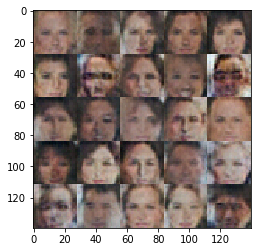

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl


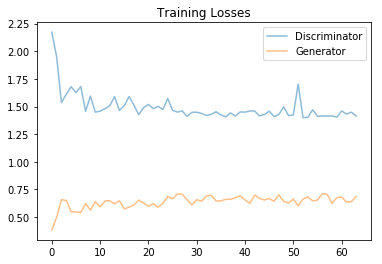

Epoch: 6/ 8 Time: 4:34:03 s. st_Tm: 0:03:48 s. mean: 4m. #Steps:4160, DLoss: 1.4942 GLoss: 0.6104 guess: 139m.
Epoch: 6/ 8 Time: 4:37:47 s. st_Tm: 0:03:43 s. mean: 4m. #Steps:4224, DLoss: 1.4178 GLoss: 0.7087 guess: 132m.
Epoch: 6/ 8 Time: 4:41:30 s. st_Tm: 0:03:42 s. mean: 4m. #Steps:4288, DLoss: 1.4395 GLoss: 0.6078 guess: 125m.
Epoch: 6/ 8 Time: 4:45:14 s. st_Tm: 0:03:44 s. mean: 4m. #Steps:4352, DLoss: 1.4123 GLoss: 0.6646 guess: 118m.


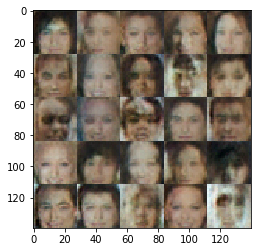

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 6/ 8 Time: 4:48:58 s. st_Tm: 0:03:43 s. mean: 4m. #Steps:4416, DLoss: 1.3883 GLoss: 0.6873 guess: 112m.
Epoch: 6/ 8 Time: 4:52:38 s. st_Tm: 0:03:40 s. mean: 4m. #Steps:4480, DLoss: 1.4115 GLoss: 0.6680 guess: 106m.
Epoch: 6/ 8 Time: 4:56:20 s. st_Tm: 0:03:41 s. mean: 4m. #Steps:4544, DLoss: 1.4120 GLoss: 0.6502 guess: 100m.
Epoch: 6/ 8 Time: 5:00:02 s. st_Tm: 0:03:41 s. mean: 4m. #Steps:4608, DLoss: 1.4287 GLoss: 0.6437 guess:  94m.


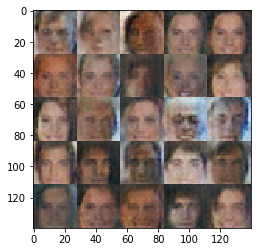

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl


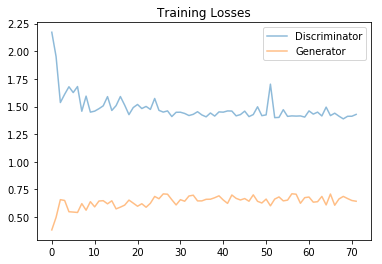

Epoch: 6/ 8 Time: 5:03:46 s. st_Tm: 0:03:44 s. mean: 4m. #Steps:4672, DLoss: 1.3820 GLoss: 0.6376 guess:  90m.
Epoch: 6/ 8 Time: 5:07:29 s. st_Tm: 0:03:42 s. mean: 4m. #Steps:4736, DLoss: 1.4008 GLoss: 0.6174 guess:  86m.
Epoch: 7/ 8 Time: 5:11:10 s. st_Tm: 0:03:40 s. mean: 4m. #Steps:4800, DLoss: 1.4236 GLoss: 0.6985 guess:  86m.
Epoch: 7/ 8 Time: 5:14:51 s. st_Tm: 0:03:41 s. mean: 4m. #Steps:4864, DLoss: 1.4161 GLoss: 0.7265 guess:  82m.


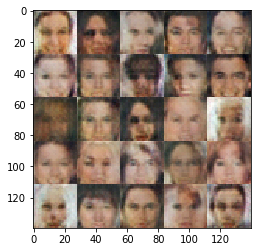

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 7/ 8 Time: 5:18:34 s. st_Tm: 0:03:42 s. mean: 4m. #Steps:4928, DLoss: 1.4681 GLoss: 0.7560 guess:  78m.
Epoch: 7/ 8 Time: 5:22:16 s. st_Tm: 0:03:42 s. mean: 4m. #Steps:4992, DLoss: 1.4060 GLoss: 0.6590 guess:  74m.
Epoch: 7/ 8 Time: 5:25:57 s. st_Tm: 0:03:40 s. mean: 4m. #Steps:5056, DLoss: 1.4494 GLoss: 0.6440 guess:  70m.
Epoch: 7/ 8 Time: 5:29:38 s. st_Tm: 0:03:41 s. mean: 4m. #Steps:5120, DLoss: 1.4292 GLoss: 0.6260 guess:  67m.


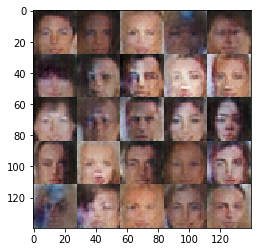

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl


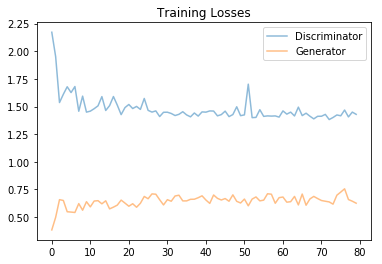

Epoch: 7/ 8 Time: 5:33:22 s. st_Tm: 0:03:43 s. mean: 4m. #Steps:5184, DLoss: 1.4204 GLoss: 0.6724 guess:  63m.
Epoch: 7/ 8 Time: 5:37:05 s. st_Tm: 0:03:42 s. mean: 4m. #Steps:5248, DLoss: 1.4285 GLoss: 0.6659 guess:  59m.
Epoch: 7/ 8 Time: 5:40:47 s. st_Tm: 0:03:42 s. mean: 4m. #Steps:5312, DLoss: 1.4410 GLoss: 0.6666 guess:  56m.
Epoch: 7/ 8 Time: 5:44:29 s. st_Tm: 0:03:41 s. mean: 4m. #Steps:5376, DLoss: 1.4036 GLoss: 0.6278 guess:  52m.


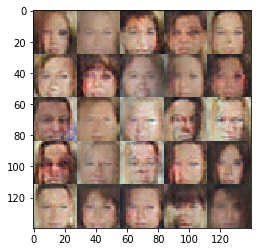

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 7/ 8 Time: 5:48:12 s. st_Tm: 0:03:43 s. mean: 4m. #Steps:5440, DLoss: 1.4157 GLoss: 0.7285 guess:  48m.
Epoch: 7/ 8 Time: 5:51:52 s. st_Tm: 0:03:39 s. mean: 4m. #Steps:5504, DLoss: 1.4118 GLoss: 0.6806 guess:  44m.
Epoch: 8/ 8 Time: 5:55:31 s. st_Tm: 0:03:39 s. mean: 4m. #Steps:5568, DLoss: 1.4477 GLoss: 0.6762 guess:  41m.
Epoch: 8/ 8 Time: 5:59:09 s. st_Tm: 0:03:38 s. mean: 4m. #Steps:5632, DLoss: 1.4109 GLoss: 0.6672 guess:  37m.


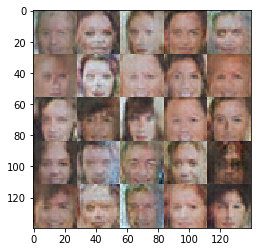

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl


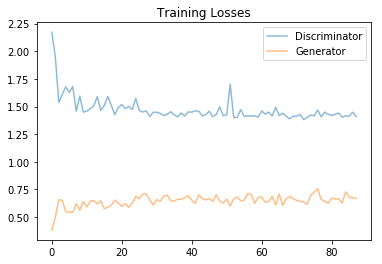

Epoch: 8/ 8 Time: 6:02:52 s. st_Tm: 0:03:42 s. mean: 4m. #Steps:5696, DLoss: 1.3923 GLoss: 0.7144 guess:  33m.
Epoch: 8/ 8 Time: 6:06:32 s. st_Tm: 0:03:40 s. mean: 4m. #Steps:5760, DLoss: 1.4199 GLoss: 0.6651 guess:  30m.
Epoch: 8/ 8 Time: 6:10:12 s. st_Tm: 0:03:40 s. mean: 4m. #Steps:5824, DLoss: 1.4429 GLoss: 0.7301 guess:  26m.
Epoch: 8/ 8 Time: 6:13:53 s. st_Tm: 0:03:40 s. mean: 4m. #Steps:5888, DLoss: 1.4212 GLoss: 0.6238 guess:  22m.


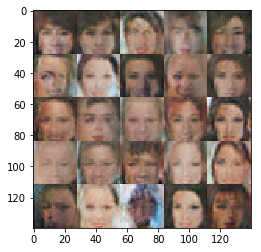

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
Epoch: 8/ 8 Time: 6:17:36 s. st_Tm: 0:03:42 s. mean: 4m. #Steps:5952, DLoss: 1.4108 GLoss: 0.7409 guess:  18m.
Epoch: 8/ 8 Time: 6:21:17 s. st_Tm: 0:03:41 s. mean: 4m. #Steps:6016, DLoss: 1.4118 GLoss: 0.7047 guess:  15m.
Epoch: 8/ 8 Time: 6:25:00 s. st_Tm: 0:03:42 s. mean: 4m. #Steps:6080, DLoss: 1.4369 GLoss: 0.6404 guess:  11m.
Epoch: 8/ 8 Time: 6:28:42 s. st_Tm: 0:03:41 s. mean: 4m. #Steps:6144, DLoss: 1.4084 GLoss: 0.7150 guess:   7m.


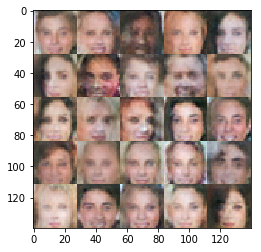

checkpoint saved
losses saved to:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl


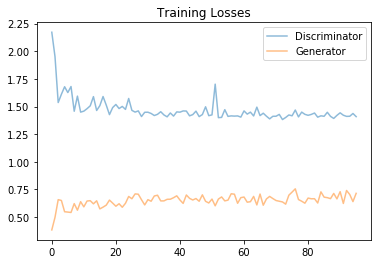

Epoch: 8/ 8 Time: 6:32:25 s. st_Tm: 0:03:43 s. mean: 4m. #Steps:6208, DLoss: 1.4051 GLoss: 0.7188 guess:   4m.
Epoch: 8/ 8 Time: 6:36:07 s. st_Tm: 0:03:41 s. mean: 4m. #Steps:6272, DLoss: 1.4154 GLoss: 0.6453 guess:   0m.
checkpoint saved


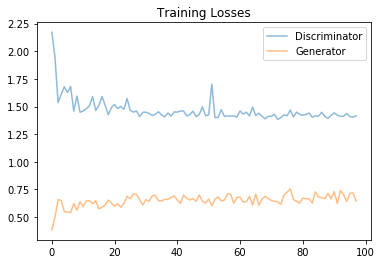

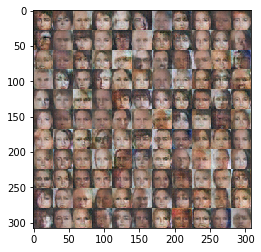

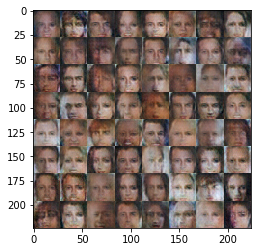

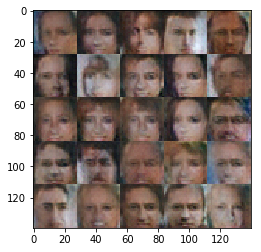

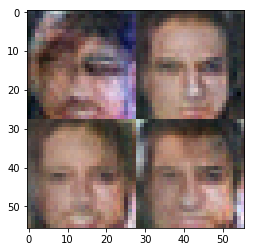

pickle should open:  ./pkl-files/saved_var_checkpoint/CelebA_run.pkl
finished training 8 epochs


In [17]:
"""
# GLOBAL VAR 
- rather than changing the params train() uses - I added these params as global 
- which I know is not strictly right, but it works for me.
"""

# std. Hyper param
batch_size      = 256
z_dim           = 100

# I created a spreadsheet to try and understand beta1, beta2, m_0, v_0 - ended up with a 40* higher lr
# I can't say anything other than: these worked for me - hope they will for you too.
learning_rate   = 0.0002
beta1           = 0.5

# to seperate the two data-runs, I will have to give the files different names 
filename        = 'CelebA_run'

#set this to [ True ], if you want to load the checkpoint and loss-file
Load_chk        =  False         #True

Gkeep_prob      = 0.6  
Dkeep_prob      = 0.4

num_mv_avg      =  12                            
steps_printline =  64
steps_images    = 256 

steps_graph     = 512


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 8

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.